# 펭귄 몸무게 예측 경진대회
1. train.csv : 학습 데이터

    - id : 샘플 아이디
    - Species: 펭귄의 종을 나타내는 문자열
    - Island : 샘플들이 수집된 Palmer Station 근처 섬 이름
    - Clutch Completion : 관찰된 펭귄 둥지의 알이 2개인 경우 Full Clutch이며 Yes로 표기
    - Culmen Length (mm) : 펭귄 옆모습 기준 부리의 가로 길이
    - Culmen Depth (mm) : 펭귄 옆모습 기준 부리의 세로 길이
    - Flipper Length (mm) : 펭귄의 팔(날개) 길이
    - Sex : 펭귄의 성별
    - Delta 15 N (o/oo)  : 토양에 따라 변화하는 안정 동위원소 15N:14N의 비율
    - Delta 13 C (o/oo) : 먹이에 따라 변화하는 안정 동위원소 13C:12C의 비율
    - Body Mass (g): 펭귄의 몸무게를 나타내는 숫자 (g)


2. test.csv : 테스트 데이터
    - train.csv 스키마에서 에서 Body Mass (g) 제외

3. sample_submissoin.csv : 제출 양식
    - id : 샘플 아이디
    - Body Mass (g) : 펭귄의 몸무게를 나타내는 숫자 (g)

[데이터 상세 설명](https://allisonhorst.github.io/palmerpenguins/)

    성인 Adélie, Chinstrap 및 Gentoo 펭귄의 둥지 관찰, 펭귄 크기 데이터 및 혈액 샘플의 동위원소 측정을 포함한 데이터입니다. 남극의 Palmer Station 근처 Palmer 군도에 있는 섬에서 관찰된 Adélie, chinstrap, Gentoo 펭귄의 먹이를 찾는 성체의 크기 측정, 클러치 관찰 및 혈액 동위원소 비율. 데이터는 Kristen Gor man 박사와 Palmer Station Long Term Ecological Research(LTER) 프로그램에 의해 수집되어 제공되었습니다.

- [참고- 분석관련](https://datascienceschool.net/03%20machine%20learning/04.01%20%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D%20%EC%98%88%EC%A0%9C.html)  
- [참고 : PCA1](https://ooyoung.tistory.com/78)
- [참고 레퍼런스](https://dacon.io/competitions/official/235862/codeshare/4068?page=1&dtype=recent)

## 1.1 Read DataSet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read Data 
train_data = pd.read_csv('../data/train.csv').sort_values(by='id',ascending=True)
test_data = pd.read_csv('../data/test.csv').sort_values(by='id',ascending=True)

# Print Data Size
print("train 데이터 크기 : %s 행 %s 열" % train_data.shape)
print("test  데이터 크기 : %s 행 %s 열" % test_data.shape)

# Species Data 짧게 변경
train_data["Species"] = train_data["Species"].apply(lambda x : x.split()[0])
test_data["Species"] = test_data["Species"].apply(lambda x : x.split()[0])

# 열이름 변경
col_rename = { 
"Clutch Completion":"Clutch",
"Culmen Length (mm)":"C_Len",
"Culmen Depth (mm)":"C_Dep",
"Flipper Length (mm)":"F_Len",
"Delta 15 N (o/oo)":"15_N",
"Delta 13 C (o/oo)":"13_C",
}
# 열이름 변경
train_data.rename(columns = col_rename, inplace=True)
test_data.rename(columns = col_rename, inplace=True)

# 열 카테고리화
cols_categorical = ["Species","Island","Clutch","Sex"]
for colName in cols_categorical:
    train_data[colName] = train_data[colName].astype('category')
    test_data[colName] = test_data[colName].astype('category')

# Data 예시출력
display( train_data.head(2) )
display( train_data.tail(2) )
display( test_data.head(2) )
display( test_data.tail(2) )

train 데이터 크기 : 114 행 11 열
test  데이터 크기 : 228 행 10 열


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g)
0,0,Gentoo,Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap,Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g)
112,112,Chinstrap,Dream,No,46.9,16.6,192,FEMALE,9.80589,-24.73735,2700
113,113,Gentoo,Biscoe,Yes,50.8,17.3,228,MALE,8.27428,-26.30019,5600


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C
0,0,Chinstrap,Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo,Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C
226,226,Chinstrap,Dream,Yes,50.5,19.6,201.0,MALE,9.8059,-24.72940
227,227,Adelie,Biscoe,Yes,37.6,19.1,194.0,MALE,9.1080,-25.89677


In [2]:
def Prepare_Data(df):
    df.at[ (df["Species"]=="Gentoo")   & (df["Sex"]=="FEMALE") ,"Cluster"] = "Gentoo_F"
    df.at[ (df["Species"]=="Gentoo")   & (df["Sex"]=="MALE")   ,"Cluster"] = "Gentoo_M"
    df.at[ (df["Species"]=="Chinstrap")& (df["Sex"]=="FEMALE") ,"Cluster"] = "Chinstrap_F"
    df.at[ (df["Species"]=="Chinstrap")& (df["Sex"]=="MALE")   ,"Cluster"] = "Chinstrap_M"
    df.at[ (df["Species"]=="Adelie")   & (df["Sex"]=="FEMALE") ,"Cluster"] = "Adelie_F"
    df.at[ (df["Species"]=="Adelie")   & (df["Sex"]=="MALE")   ,"Cluster"] = "Adelie_M"
    df['Cluster'] = df['Cluster'].astype('category')
    return df.sort_values(by='Cluster',ascending=False)

train_data = Prepare_Data(train_data)
test_data = Prepare_Data(test_data)

cols = ["id","Cluster","F_Len","C_Len","C_Dep","15_N","13_C"]
train_X = train_data.loc[:,cols]
train_y = train_data.loc[:,["id","Cluster","Body Mass (g)"]]
test_X  = test_data.loc[:,cols]

display(train_X.head(1))
display(train_y.head(1))
display(test_X.head(1))

,id,Cluster,F_Len,C_Len,C_Dep,15_N,13_C
0,0,Gentoo_M,220,50.0,15.3,8.30515,-25.19017


,id,Cluster,Body Mass (g)
0,0,Gentoo_M,5550


,id,Cluster,F_Len,C_Len,C_Dep,15_N,13_C
114,114,Gentoo_M,220.0,48.5,14.1,8.39867,-26.79358


In [3]:
from sklearn.naive_bayes  import GaussianNB
from sklearn.metrics      import accuracy_score

# Sex 결측값 예측 학습모델 생성
GNB = GaussianNB()
cols = ['Species','C_Len', 'C_Dep', 'F_Len'] # Species는 One Hot Encoding

# Sex 결측값 예측 학습모델 학습
train_Sex_Y = train_data[train_data['Sex'].notnull()]['Sex']
train_Sex_X = train_data[train_data['Sex'].notnull()][cols]
train_Sex_X = pd.get_dummies(train_Sex_X, columns= ['Species'])
GNB.fit(train_Sex_X,train_Sex_Y)
print("Sex 학습 정확도 :",accuracy_score(train_Sex_Y, GNB.predict(train_Sex_X)))

# test_Sex 데이터 예측 정확도
cols = ['Species','C_Len', 'C_Dep', 'F_Len']
x_test = test_data[test_data['Sex'].notnull()][cols]
x_test = pd.get_dummies(x_test, columns= ['Species'])
y_pred = GNB.predict(x_test)
y_true = test_data[test_data['Sex'].notnull()]['Sex']
print("Sex 예측 정확도 :",accuracy_score(y_true, y_pred))

Sex 학습 정확도 : 0.8558558558558559
Sex 예측 정확도 : 0.8333333333333334


In [4]:
# train 결측값 체우기
idx = train_data['Sex'].isnull() ; 

display(train_data[idx]) #######################################################
train_Sex_nan = train_data[idx][cols]
train_Sex_nan = pd.get_dummies(train_Sex_nan, columns= ['Species'])
if train_Sex_nan.shape[0] > 0 : 
    train_data.at[train_data['Sex'].isnull(),['Sex']] = GNB.predict(train_Sex_nan)
else : print("이미 결측값 체움")
    
train_data = Prepare_Data(train_data)
display(train_data[idx]) #######################################################

,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g),Cluster
6,6,Adelie,Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250,NaN
8,8,Adelie,Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475,NaN
70,70,Gentoo,Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650,NaN


C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Body Mass (g),Cluster
70,70,Gentoo,Biscoe,Yes,46.2,14.4,214,FEMALE,8.24253,-26.81540,4650,Gentoo_F
6,6,Adelie,Torgersen,Yes,42.0,20.2,190,MALE,9.13362,-25.09368,4250,Adelie_M
8,8,Adelie,Torgersen,Yes,34.1,18.1,193,FEMALE,NaN,NaN,3475,Adelie_F


In [5]:
# test 결측값 체우기
idx = test_data['Sex'].isnull()

display(test_data[idx]) #######################################################
test_Sex_nan = test_data[idx][cols]
test_Sex_nan = pd.get_dummies(test_Sex_nan, columns= ['Species'])
if test_Sex_nan.shape[0] > 0 : 
    test_data.at[test_data['Sex'].isnull(),['Sex']] = GNB.predict(test_Sex_nan)
else : print("이미 결측값 체움")
    
test_data = Prepare_Data(test_data)
display(test_data[idx]) #######################################################

,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Cluster
46,46,Adelie,Torgersen,Yes,37.8,17.1,186.0,NaN,8.63243,-25.21315,NaN
81,81,Adelie,Dream,Yes,37.5,18.9,179.0,NaN,NaN,NaN,NaN
98,98,Gentoo,Biscoe,Yes,47.3,13.8,216.0,NaN,8.25818,-26.23886,NaN
152,152,Gentoo,Biscoe,Yes,44.5,15.7,217.0,NaN,8.04111,-26.18444,NaN
205,205,Adelie,Torgersen,Yes,37.8,17.3,180.0,NaN,NaN,NaN,NaN
209,209,Gentoo,Biscoe,Yes,44.5,14.3,216.0,NaN,7.96621,-25.69327,NaN


C:\ProgramData\Anaconda3\envs\py32\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Cluster
152,152,Gentoo,Biscoe,Yes,44.5,15.7,217.0,FEMALE,8.04111,-26.18444,Gentoo_F
98,98,Gentoo,Biscoe,Yes,47.3,13.8,216.0,FEMALE,8.25818,-26.23886,Gentoo_F
209,209,Gentoo,Biscoe,Yes,44.5,14.3,216.0,FEMALE,7.96621,-25.69327,Gentoo_F
46,46,Adelie,Torgersen,Yes,37.8,17.1,186.0,FEMALE,8.63243,-25.21315,Adelie_F
81,81,Adelie,Dream,Yes,37.5,18.9,179.0,FEMALE,NaN,NaN,Adelie_F
205,205,Adelie,Torgersen,Yes,37.8,17.3,180.0,FEMALE,NaN,NaN,Adelie_F


In [6]:
df_group_mean = test_data.groupby('Cluster').mean()
display(df_group_mean)

# 호출 형식 
# df_group_mean.loc['Adelie_F']['15_N']

# 13_C , 15_N 열에 해당 Cluster 평균값으로 결측값 입력
for col in ['13_C','15_N']:
    for cat in list(train_data['Cluster'].cat.categories):
        test_data.at[test_data['Cluster']==cat,col] = test_data.loc[test_data['Cluster']==cat,col].fillna(df_group_mean.loc[cat][col])
        train_data.at[train_data['Cluster']==cat,col] = train_data.loc[train_data['Cluster']==cat,col].fillna(df_group_mean.loc[cat][col])

,id,C_Len,C_Dep,F_Len,15_N,13_C
Cluster,,,,,,
Adelie_F,117.327586,37.237931,17.644828,187.672414,8.819026,-25.771811
Adelie_M,115.634615,40.507692,19.115385,192.730769,8.895895,-25.823286
Chinstrap_F,122.400000,46.700000,17.465000,191.100000,9.167210,-24.605492
Chinstrap_M,109.173913,51.178261,19.278261,199.652174,9.458425,-24.528740
Gentoo_F,105.894737,45.705263,14.181579,212.684211,8.181777,-26.200890
Gentoo_M,110.189189,49.224324,15.594595,220.594595,8.270893,-26.056440


### ML 분석용으로 테이블 수정

- [참고 레퍼런스](https://dacon.io/competitions/official/235862/codeshare/4068?page=1&dtype=recent)

In [7]:
from sklearn.model_selection import train_test_split
seed = 7

cols = ['Cluster','C_Len', 'C_Dep', 'F_Len','15_N', '13_C']
X_all = pd.get_dummies(train_data[cols], columns= ['Cluster'])
y_all =train_data['Body Mass (g)']

######### train set 만들기
X_train, X_valid, y_train, y_valid = train_test_split(
    pd.get_dummies(train_data[cols], columns= ['Cluster']),
    train_data['Body Mass (g)'],test_size=0.2,random_state=seed)

######### test set 만들기
test_data = test_data.sort_values(by='id',ascending=True)
X_test = pd.get_dummies(test_data[cols], columns= ['Cluster'])

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

def Scale_unit(arr,div=1):
    return np.array( [ x - x%5 + ( div if x%div > div/2 else 0) for x in arr ] )
    # Scale_unit(range(10))
    # array([ 0,  0,  0,  5,  5,  5,  5,  5, 10, 10])

class custom_LinearRegression(LinearRegression):
    def predict(self,df):
        return Scale_unit(super().predict(df))

class custom_Lasso(Lasso):
    def predict(self,df):
        return Scale_unit(super().predict(df))
    
class custom_KNeighborsRegressor(KNeighborsRegressor):
    def predict(self,df):
        return Scale_unit(super().predict(df))
    
class custom_DecisionTreeRegressor(DecisionTreeRegressor):
    def predict(self,df):
        return Scale_unit(super().predict(df))
    
class custom_ElasticNet(ElasticNet):
    def predict(self,df):
        return Scale_unit(super().predict(df))
    
class custom_SVR(SVR):
    def predict(self,df):
        return Scale_unit(super().predict(df))

class custom_RandomForestRegressor(RandomForestRegressor):
    def predict(self,df):
        return Scale_unit(super().predict(df))
    
class custom_AdaBoostRegressor(AdaBoostRegressor):
    def predict(self,df):
        return Scale_unit(super().predict(df))
    
class custom_ExtraTreesRegressor(ExtraTreesRegressor):
    def predict(self,df):
        return Scale_unit(super().predict(df))

### Base

In [9]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Xtree',ExtraTreesRegressor()))

models.append(('ctm_LR',custom_LinearRegression()))
models.append(('ctm_LASSO',custom_Lasso()))
models.append(('ctm_KNN',custom_KNeighborsRegressor()))
models.append(('ctm_DTR',custom_DecisionTreeRegressor()))
models.append(('ctm_EN',custom_ElasticNet()))
models.append(('ctm_SVM',custom_SVR()))
models.append(('ctm_RFR',custom_RandomForestRegressor()))
models.append(('ctm_AdaR',custom_AdaBoostRegressor()))
models.append(('ctm_Xtree',custom_ExtraTreesRegressor()))

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

results =[]
names = []
scoring = 'neg_root_mean_squared_error'

for name, model in models:
    kfold = KFold(n_splits=10,random_state=7,shuffle = True)
    cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
    print(msg)

LR : -277.106156 (86.879229) 
LASSO : -277.650632 (87.870224) 
KNN : -332.453918 (87.491132) 
CART : -350.534270 (64.248025) 
EN : -326.502678 (96.772484) 
SVM : -791.315537 (124.226520) 
RFR : -308.724094 (71.280222) 
AdaR : -306.038578 (72.727279) 
Xtree : -307.597103 (74.486634) 
ctm_LR : -277.252221 (86.765952) 
ctm_LASSO : -277.404601 (87.699143) 
ctm_KNN : -332.453918 (87.491132) 
ctm_DTR : -385.303414 (69.138758) 
ctm_EN : -326.503908 (96.692124) 
ctm_SVM : -790.749676 (124.496383) 
ctm_RFR : -310.452192 (66.743770) 
ctm_AdaR : -316.876376 (80.153341) 
ctm_Xtree : -307.733904 (75.295183) 


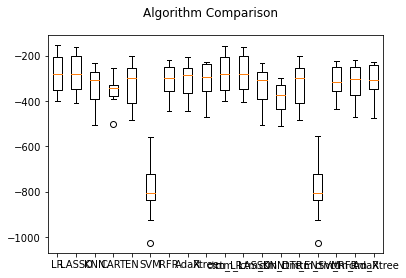

In [11]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### standardization

In [12]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

pipelines = []
pipelines.append(('ScaledLR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO',Pipeline([('Scaler',preprocessing.StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledKNN',Pipeline([('Scaler',preprocessing.StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART',Pipeline([('Scaler',preprocessing.StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledEN',Pipeline([('Scaler',preprocessing.StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledSVM',Pipeline([('Scaler',preprocessing.StandardScaler()),('SVM',SVR())])))
pipelines.append(('ScaledRFR',Pipeline([('Scaler',preprocessing.StandardScaler()),('RFR',RandomForestRegressor())])))
pipelines.append(('ScaledAdaR',Pipeline([('Scaler',preprocessing.StandardScaler()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('ScaledXtree',Pipeline([('Scaler',preprocessing.StandardScaler()),('Xtree',ExtraTreesRegressor())])))

pipelines.append(('ctm_ScaledLR',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_LR',custom_LinearRegression())])))
pipelines.append(('ctm_ScaledLASSO',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_LASSO',custom_Lasso())])))
pipelines.append(('ctm_ScaledKNN',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_KNN',custom_KNeighborsRegressor())])))
pipelines.append(('ctm_ScaledCART',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_CART',custom_DecisionTreeRegressor())])))
pipelines.append(('ctm_ScaledEN',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_EN',custom_ElasticNet())])))
pipelines.append(('ctm_ScaledSVM',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_SVM',custom_SVR())])))
pipelines.append(('ctm_ScaledRFR',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_RFR',custom_RandomForestRegressor())])))
pipelines.append(('ctm_ScaledAdaR',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_AdaR',AdaBoostRegressor())])))
pipelines.append(('ctm_ScaledXtree',Pipeline([('Scaler',preprocessing.StandardScaler()),('ctm_Xtree',custom_AdaBoostRegressor())])))


results_scaled =[]
names_scaled = []
for name, model in pipelines:
    kfold = KFold(n_splits=10,random_state=7,shuffle = True)
    cv_results = cross_val_score(model,X_train,y_train
                                 ,cv= kfold,scoring=scoring)
    results_scaled.append(cv_results)
    names_scaled.append(name)
    msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
    print(msg)

ScaledLR : -277.106156 (86.879229) 
ScaledLASSO : -277.277639 (86.691124) 
ScaledKNN : -293.484821 (82.222049) 
ScaledCART : -434.440673 (82.916766) 
ScaledEN : -290.300443 (95.661923) 
ScaledSVM : -779.464140 (123.502954) 
ScaledRFR : -302.472026 (75.590589) 
ScaledAdaR : -315.369363 (82.372880) 
ScaledXtree : -307.432608 (78.096249) 
ctm_ScaledLR : -277.252221 (86.765952) 
ctm_ScaledLASSO : -277.121959 (86.813611) 
ctm_ScaledKNN : -293.484821 (82.222049) 
ctm_ScaledCART : -402.875807 (81.735349) 
ctm_ScaledEN : -290.066492 (95.870833) 
ctm_ScaledSVM : -779.682517 (123.911290) 
ctm_ScaledRFR : -301.224996 (76.902469) 
ctm_ScaledAdaR : -305.524929 (85.000793) 
ctm_ScaledXtree : -305.786507 (84.993503) 


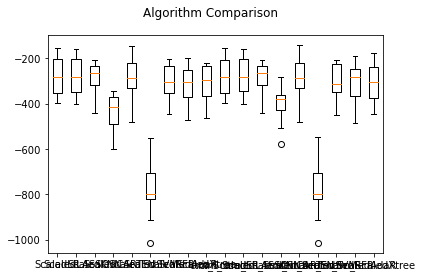

In [13]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_scaled)
ax.set_xticklabels(names_scaled)
plt.show()

### Normalization

In [14]:
pipelines = []
pipelines.append(('NormLR',Pipeline([('Scaler',preprocessing.Normalizer()),('LR',LinearRegression())])))
pipelines.append(('NormLASSO',Pipeline([('Scaler',preprocessing.Normalizer()),('LASSO',Lasso())])))
pipelines.append(('NormKNN',Pipeline([('Scaler',preprocessing.Normalizer()),('KNN',KNeighborsRegressor())])))
pipelines.append(('NormCART',Pipeline([('Scaler',preprocessing.Normalizer()),('CART',DecisionTreeRegressor())])))
pipelines.append(('NormEN',Pipeline([('Scaler',preprocessing.Normalizer()),('EN',ElasticNet())])))
pipelines.append(('NormSVM',Pipeline([('Scaler',preprocessing.Normalizer()),('SVM',SVR())])))
pipelines.append(('NormRFR',Pipeline([('Scaler',preprocessing.Normalizer()),('RFR',RandomForestRegressor())])))
pipelines.append(('NormAdaR',Pipeline([('Scaler',preprocessing.Normalizer()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('NormXtree',Pipeline([('Scaler',preprocessing.Normalizer()),('Xtree',ExtraTreesRegressor())])))


pipelines.append(('ctm_NormLR',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_LR',custom_LinearRegression())])))
pipelines.append(('ctm_NormLASSO',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_LASSO',custom_Lasso())])))
pipelines.append(('ctm_NormKNN',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_KNN',custom_KNeighborsRegressor())])))
pipelines.append(('ctm_NormCART',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_CART',custom_DecisionTreeRegressor())])))
pipelines.append(('ctm_NormEN',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_EN',custom_ElasticNet())])))
pipelines.append(('ctm_NormSVM',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_SVM',custom_SVR())])))
pipelines.append(('ctm_NormRFR',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_RFR',custom_RandomForestRegressor())])))
pipelines.append(('ctm_NormAdaR',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_AdaR',AdaBoostRegressor())])))
pipelines.append(('ctm_NormXtree',Pipeline([('Scaler',preprocessing.Normalizer()),('ctm_Xtree',custom_AdaBoostRegressor())])))

results_norm =[]
names_norm = []
for name, model in pipelines:
    kfold = KFold(n_splits=10,random_state=7,shuffle = True)
    cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
    results_norm.append(cv_results)
    names_norm.append(name)
    msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
    print(msg)

NormLR : -284.205028 (89.635342) 
NormLASSO : -497.541336 (140.789777) 
NormKNN : -319.418454 (73.838347) 
NormCART : -410.478977 (83.371213) 
NormEN : -779.700082 (118.476044) 
NormSVM : -792.055627 (124.216263) 
NormRFR : -308.922265 (60.230579) 
NormAdaR : -301.161184 (48.870556) 
NormXtree : -316.187157 (74.490918) 
ctm_NormLR : -284.158514 (89.397359) 
ctm_NormLASSO : -497.685521 (140.856476) 
ctm_NormKNN : -319.418454 (73.838347) 
ctm_NormCART : -417.210162 (88.319102) 
ctm_NormEN : -779.787618 (118.660455) 
ctm_NormSVM : -791.384209 (124.401880) 
ctm_NormRFR : -304.278350 (63.562954) 
ctm_NormAdaR : -311.690351 (60.344183) 
ctm_NormXtree : -306.759413 (70.110621) 


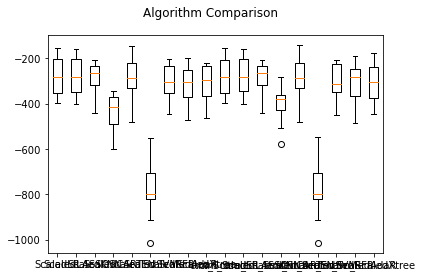

In [15]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_scaled)
ax.set_xticklabels(names_scaled)
plt.show()

### 비교

<Figure size 1152x576 with 0 Axes>

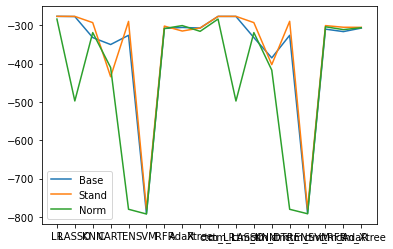

In [17]:
compare_algo_mean = pd.DataFrame([ i.mean() for i in results],columns=['Base'],index=names)
compare_algo_mean['Stand'] = [ i.mean() for i in results_scaled]
compare_algo_mean['Norm'] = [ i.mean() for i in results_norm]

plt.figure(figsize=(16,8))
ax =compare_algo_mean.plot()
plt.xticks(range(len(compare_algo_mean.index)), compare_algo_mean.index)
plt.show()

In [18]:
display(compare_algo_mean.sort_values(by='Base',ascending=False).head(6))
display(compare_algo_mean.sort_values(by='Stand',ascending=False).head(6))
display(compare_algo_mean.sort_values(by='Norm',ascending=False).head(6))

,Base,Stand,Norm
LR,-277.106156,-277.106156,-284.205028
ctm_LR,-277.252221,-277.252221,-284.158514
ctm_LASSO,-277.404601,-277.121959,-497.685521
LASSO,-277.650632,-277.277639,-497.541336
AdaR,-306.038578,-315.369363,-301.161184
Xtree,-307.597103,-307.432608,-316.187157


,Base,Stand,Norm
LR,-277.106156,-277.106156,-284.205028
ctm_LASSO,-277.404601,-277.121959,-497.685521
ctm_LR,-277.252221,-277.252221,-284.158514
LASSO,-277.650632,-277.277639,-497.541336
ctm_EN,-326.503908,-290.066492,-779.787618
EN,-326.502678,-290.300443,-779.700082


,Base,Stand,Norm
ctm_LR,-277.252221,-277.252221,-284.158514
LR,-277.106156,-277.106156,-284.205028
AdaR,-306.038578,-315.369363,-301.161184
ctm_RFR,-310.452192,-301.224996,-304.278350
ctm_Xtree,-307.733904,-305.786507,-306.759413
RFR,-308.724094,-302.472026,-308.922265


#### 앙상블

In [19]:
from sklearn.metrics import mean_squared_error
import math 

errors = []
pred_valid=[]
pred_test = []

scaler = preprocessing.StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_valid = scaler.transform(X_valid)
scaled_X_test = scaler.transform(X_test)

In [20]:
# ctm_Lasso
ctm_lasso = custom_Lasso()
ctm_lasso.fit(X_train,y_train)
ctm_lasso_valid = ctm_lasso.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, ctm_lasso_valid))
errors.append(('ctm_Lasso',rmse))
pred_valid.append(('ctm_Lasso',ctm_lasso_valid))
ctm_lasso_test = ctm_lasso.predict(X_test)
pred_test.append(('ctm_Lasso',ctm_lasso_test))

In [21]:
# Lasso
lasso = Lasso()
lasso.fit(X_train,y_train)
lasso_valid = lasso.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lasso_valid))
errors.append(('Lasso',rmse))
pred_valid.append(('Lasso',lasso_valid))
lasso_test = lasso.predict(X_test)
pred_test.append(('Lasso',lasso_test))

In [22]:
# ctm_scaled LR
ctm_LR =custom_LinearRegression()
ctm_LR.fit(scaled_X_train,y_train)
ctm_lr_valid = ctm_LR.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, ctm_lr_valid))
errors.append(('ctm_LR',rmse))
pred_valid.append(('ctm_LR',ctm_lr_valid))
ctm_lr_test = ctm_LR.predict(scaled_X_test)
pred_test.append(('ctm_LR',ctm_lr_test))

In [23]:
# ctm_scaled LR
LR =LinearRegression()
LR.fit(scaled_X_train,y_train)
lr_valid = LR.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lr_valid))
errors.append(('LR',rmse))
pred_valid.append(('LR',lr_valid))
lr_test = LR.predict(scaled_X_test)
pred_test.append(('LR',lr_test))

## Write to CSV

In [24]:
for name, error in errors: 
    print("%s \t: %s" % (name,error))

ctm_Lasso 	: 413.4362891878159
Lasso 	: 412.46506076692793
ctm_LR 	: 406.6283956807653
LR 	: 406.0611543573298


In [25]:
display(X_test.head(2))
display(test_data.head(2))

,C_Len,C_Dep,F_Len,15_N,13_C,Cluster_Adelie_F,Cluster_Adelie_M,Cluster_Chinstrap_F,Cluster_Chinstrap_M,Cluster_Gentoo_F,Cluster_Gentoo_M
0,52.0,20.7,210.0,9.43146,-24.68440,0,0,0,1,0,0
1,55.9,17.0,228.0,8.31180,-26.35425,0,0,0,0,0,1


,id,Species,Island,Clutch,C_Len,C_Dep,F_Len,Sex,15_N,13_C,Cluster
0,0,Chinstrap,Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440,Chinstrap_M
1,1,Gentoo,Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425,Gentoo_M


In [26]:
import os

for pred in pred_test:
    name, result = pred
    filePath = os.path.join(os.getcwd(),f"penguin_submission({name}).csv")
    
    submission = pd.DataFrame(test_data['id'])
    submission['Body Mass (g)'] = result
    submission.to_csv(filePath, index=False)
    print(filePath)
    display(submission.head(3))
    
os.startfile(os.getcwd()) 

C:\Users\pwb1128\Documents\GitHub\MachineLearning-Study\Penguin_Weight\wbpark\penguin_submission(ctm_Lasso).csv


,id,Body Mass (g)
0,0,4316.0
1,1,5740.0
2,2,3636.0


C:\Users\pwb1128\Documents\GitHub\MachineLearning-Study\Penguin_Weight\wbpark\penguin_submission(Lasso).csv


,id,Body Mass (g)
0,0,4319.814357
1,1,5740.260615
2,2,3639.618069


C:\Users\pwb1128\Documents\GitHub\MachineLearning-Study\Penguin_Weight\wbpark\penguin_submission(ctm_LR).csv


,id,Body Mass (g)
0,0,4306.0
1,1,5751.0
2,2,3641.0


C:\Users\pwb1128\Documents\GitHub\MachineLearning-Study\Penguin_Weight\wbpark\penguin_submission(LR).csv


,id,Body Mass (g)
0,0,4306.638261
1,1,5750.786223
2,2,3642.695575
